### In this part we would be focussing on Segmenting Customers as every customer has different needs and they have their own distinct profile. We would be segmenting customers using RFM (Recency - Frequency - Monetary Value) Clustering.

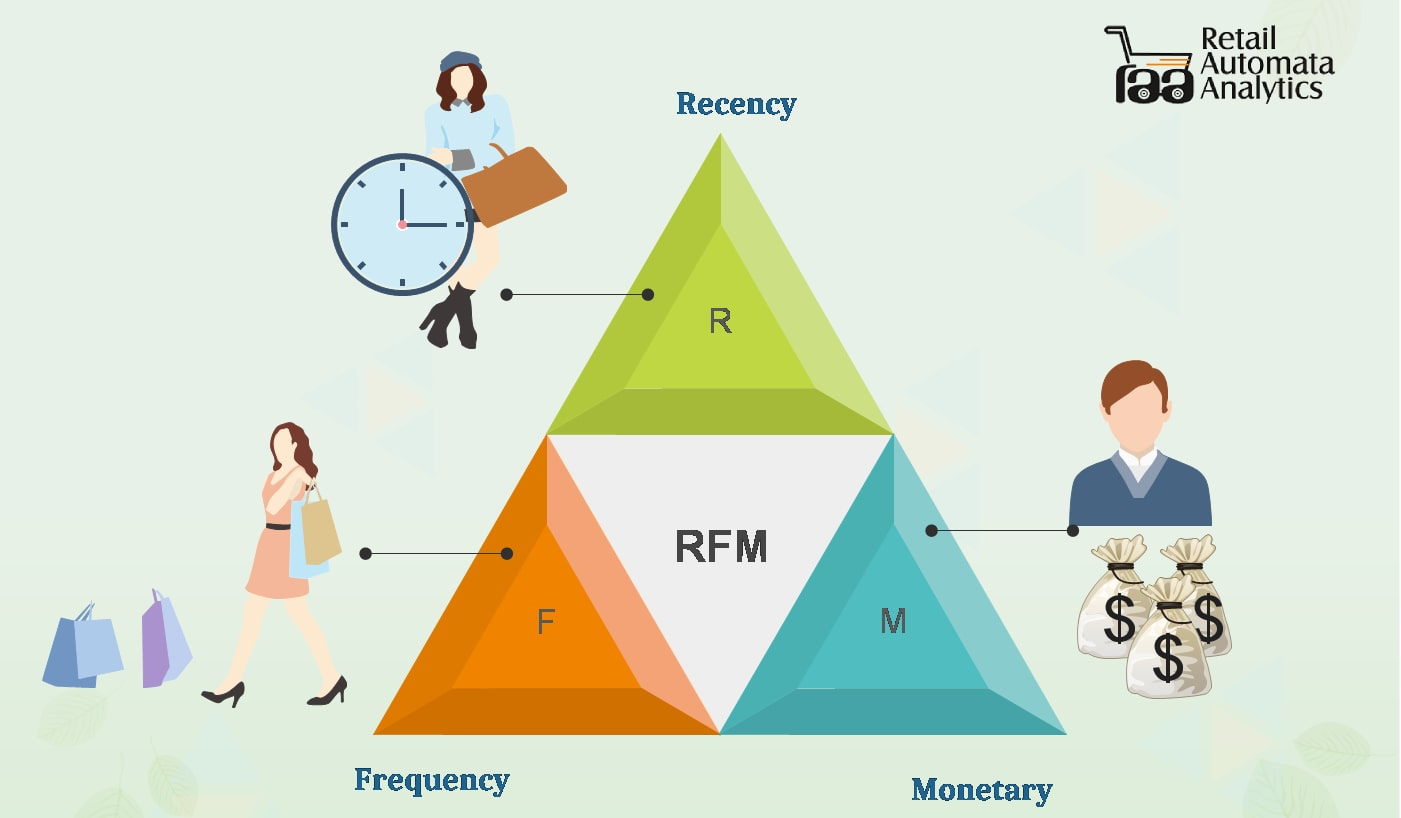

Our segments will be as follows:
- Low Value: Less Active Customers, not very frequent buyers & genrating very low or zero revenue
- Mid Value: Often using the platform more than low value and less than high value, and generates a moderate revenue
- High Value: Possessing very less inactivity, driving most of the revenue, and very frequent buyers. We do not wanna lose this group

In [1]:
# importing required libraries
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#inititate Plotly
pyoff.init_notebook_mode()

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# k-means
from sklearn.cluster import KMeans

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
# Importing Dataset
df = pd.read_excel("Online Retail.xlsx")

#### To have a better understading of the clusters, we would be using only UK data

In [4]:
df_uk = df.query("Country == 'United Kingdom'").reset_index(drop=True)

### Recency

#### While calculating Recency, we will be finding the most recent purchase date for every customer and see the number of inactive days for them. Then, we will be implementing K-means clustering to assign a recency score to Customers

In [5]:
# Creating a Customer Data Frame to keep CustomerID and Segmentation Score
df_customer = pd.DataFrame(df['CustomerID'].unique())
df_customer.columns = ['CustomerID']

# Get the max purchase date for each customer and storing it in a new dataframe
df_max_purchase = df_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_customer = pd.merge(df_customer, df_max_purchase[['CustomerID','Recency']], on='CustomerID')

df_customer.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       31
2     13748.0       95
3     15100.0      329
4     15291.0       25

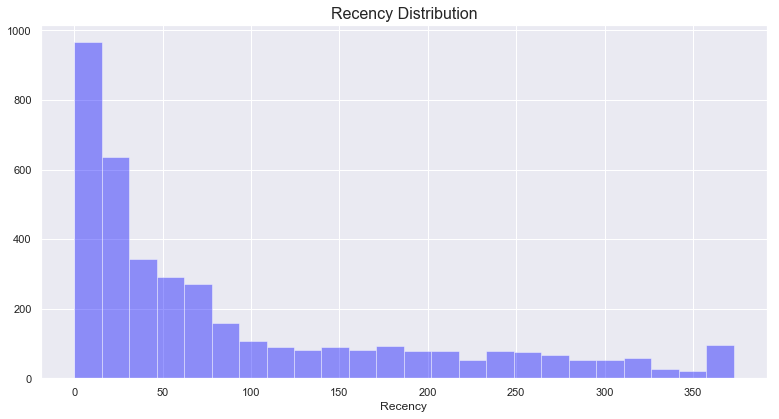

In [6]:
#plot a recency histogram

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid')
sns.distplot(df_customer['Recency'], kde= False, color='blue')
plt.title("Recency Distribution", fontsize = 16);

In [7]:
# describing our recency data frame
df_customer.describe()

CustomerID      Recency
count   3950.000000  3950.000000
mean   15562.029367    90.778481
std     1576.848325   100.230349
min    12346.000000     0.000000
25%    14208.250000    16.000000
50%    15571.500000    49.000000
75%    16913.750000   142.000000
max    18287.000000   373.000000

We can see that, even if the Mean is 90.78, but the median is 49, and our histogram also shows right skewness of Recency.

#### Applying K-means clustering to assign a recency score. We will be using Elbow Method to find out the optimal cluster number for optimal inertia.

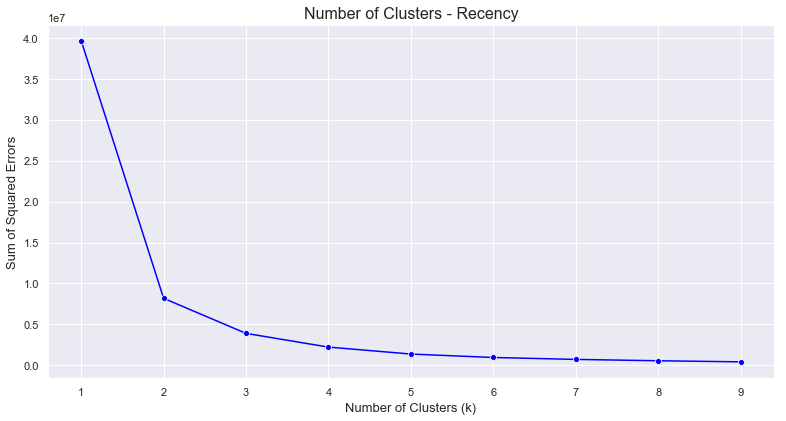

In [8]:
sse = {}
df_recency = df_customer[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid')
sns.lineplot(list(sse.keys()), list(sse.values()), marker='o', color='blue')
plt.title("Number of Clusters - Recency", fontsize = 16)
plt.xlabel("Number of Clusters (k)", fontsize = 13)
plt.ylabel("Sum of Squared Errors", fontsize = 13);

From the above Elbow plot, we can see that 3 is an optimal one, but we will be proceeding with 4.

In [9]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Recency']])
df_customer['RecencyCluster'] = kmeans.predict(df_customer[['Recency']])

# function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_customer = order_cluster('RecencyCluster', 'Recency',df_customer,False)

In [10]:
# Let's see how our recency looks like for each cluster
df_customer.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min     25%    50%     75%  \
RecencyCluster                                                                
0                478.0  304.393305  41.183489  245.0  266.25  300.0  336.00   
1                568.0  184.625000  31.753602  132.0  156.75  184.0  211.25   
2                954.0   77.679245  22.850898   48.0   59.00   72.5   93.00   
3               1950.0   17.488205  13.237058    0.0    6.00   16.0   28.00   

                  max  
RecencyCluster         
0               373.0  
1               244.0  
2               131.0  
3                47.0

All the recency clusters have different characteristics. Our Recency Cluster 3 has most recent customers whereas 0 has the most inactive ones.

### Frequency

#### While calculating frequency, we will be looking at the total number of orders for each customer.

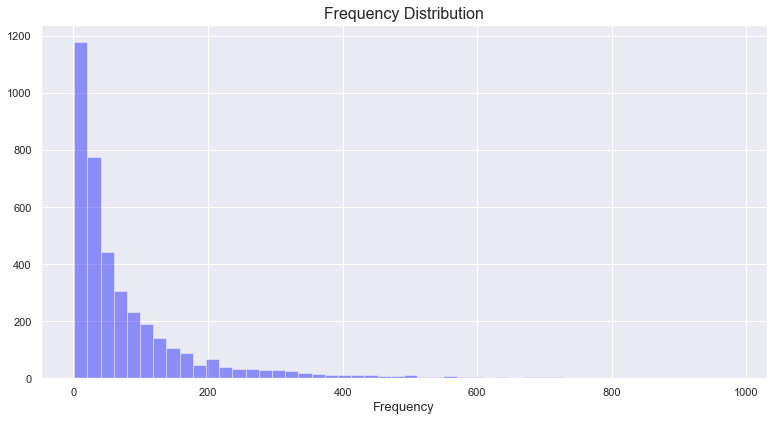

In [11]:
# creating a dataframe to store order counts for each user
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']

# add this data to our main dataframe
df_customer = pd.merge(df_customer, df_frequency, on='CustomerID')

#  Plotting a histogram for Frequency
plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid')
sns.distplot(df_customer.query('Frequency < 1000')['Frequency'], kde= False, color='blue')
plt.title("Frequency Distribution", fontsize = 16);
plt.xlabel("Frequency", fontsize=13);

#### Creating Frequency Clusters with K-means algorithm

In [12]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Frequency']])
df_customer['FrequencyCluster'] = kmeans.predict(df_customer[['Frequency']])

#order the frequency cluster
df_customer = order_cluster('FrequencyCluster', 'Frequency',df_customer,True)

#see details of each cluster
df_customer.groupby('FrequencyCluster')['Frequency'].describe()

count         mean          std     min     25%     50%  \
FrequencyCluster                                                             
0                 3496.0    49.525744    44.954212     1.0    15.0    33.0   
1                  429.0   331.221445   133.856510   191.0   228.0   287.0   
2                   22.0  1313.136364   505.934524   872.0   988.5  1140.0   
3                    3.0  5917.666667  1805.062418  4642.0  4885.0  5128.0   

                     75%     max  
FrequencyCluster                  
0                   73.0   190.0  
1                  399.0   803.0  
2                 1452.0  2782.0  
3                 6555.5  7983.0

Here, high frequency indicates better customers. So, we can say that Frequency Cluster 3 is having best customers

### Monetary

#### We would be clustering our customer based on the Revenue (UnitPrice * Quantity) they are generating for our business.

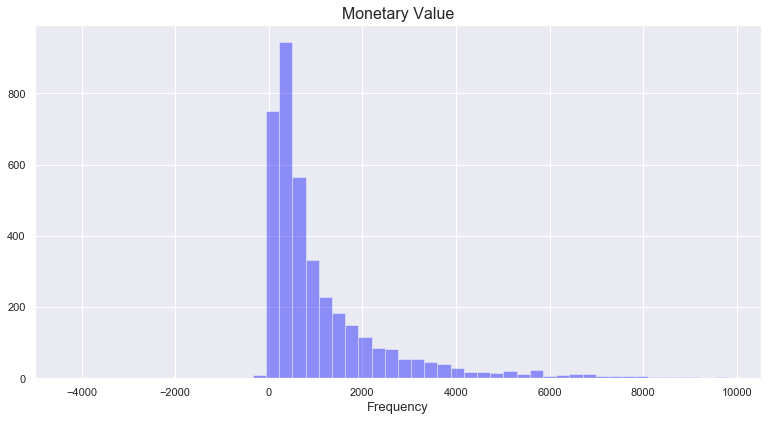

In [13]:
# Calculate Revenue for each customer
df_uk['Monetary'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_monetary = df_uk.groupby('CustomerID')['Monetary'].sum().reset_index()

# merge it with customer dataframe
df_customer = pd.merge(df_customer, df_monetary, on='CustomerID')

# plotting a histogram for monetary(revenue)
plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid')
sns.distplot(df_customer.query("Monetary < 10000")['Monetary'], kde= False, color='blue')
plt.title("Monetary Value", fontsize = 16);
plt.xlabel("Frequency", fontsize=13);

#### Creating Monetary Clusters with K-means algorithm

In [14]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Monetary']])
df_customer['MonetaryCluster'] = kmeans.predict(df_customer[['Monetary']])

#order the frequency cluster
df_customer = order_cluster('MonetaryCluster', 'Monetary',df_customer,True)

#see details of each cluster
df_customer.groupby('MonetaryCluster')['Monetary'].describe()

count           mean           std        min         25%  \
MonetaryCluster                                                               
0                3687.0     907.254414    921.910820   -4287.63     263.115   
1                 234.0    7760.699530   3637.173671    4330.67    5161.485   
2                  27.0   43070.445185  15939.249588   25748.35   28865.490   
3                   2.0  221960.330000  48759.481478  187482.17  204721.250   

                       50%         75%        max  
MonetaryCluster                                    
0                   572.56    1258.220    4314.72  
1                  6549.38    9142.305   21535.90  
2                 36351.42   53489.790   88125.38  
3                221960.33  239199.410  256438.49

### Calculating Overall RFM Score

#### Let us now create an overall score for R, F, & M

In [15]:
# Calculating overall Score
df_customer['RFM_Score'] = df_customer['RecencyCluster'] + df_customer['FrequencyCluster'] + df_customer['MonetaryCluster']
df_customer.groupby('RFM_Score')['Recency', 'Frequency', 'Monetary'].mean()

Recency    Frequency       Monetary
RFM_Score                                        
0          304.584388    21.995781     303.339705
1          185.362989    32.596085     498.087546
2           78.991304    46.963043     868.082991
3           20.689610    68.419590    1091.416414
4           14.892617   271.755034    3607.097114
5            9.662162   373.290541    9136.946014
6            7.740741   876.037037   22777.914815
7            1.857143  1272.714286  103954.025714
8            1.333333  5917.666667   42177.930000

#### The above overall RFM score leary shows that customers with score 8 is our best customers whereas 0 is the worst. 
We will name this score as below: 
- 0 to 2: Low Value
- 3 to 4: Mid Value
- 5+: High Value

In [16]:
df_customer['Segment'] = 'Low-Value'
df_customer.loc[df_customer['RFM_Score']>2, 'Segment'] = 'Mid-Value'
df_customer.loc[df_customer['RFM_Score']>4, 'Segment'] = 'High-Value'

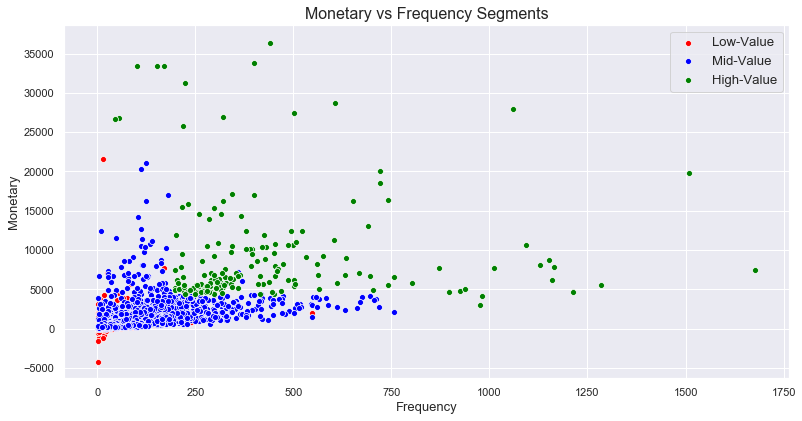

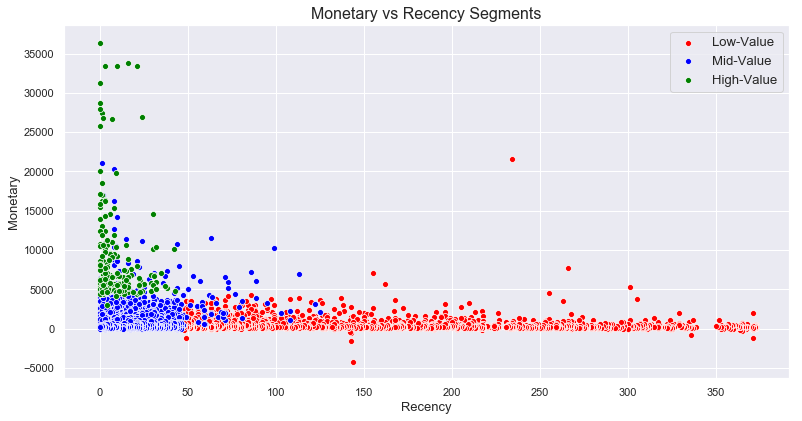

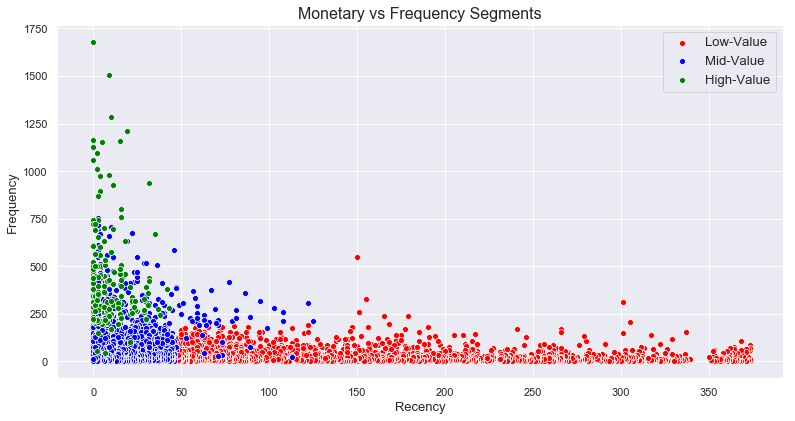

In [17]:
# Monetary vs Frequency - plots
df_graph = df_customer.query("Monetary < 50000 and Frequency < 2000")

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid', font_scale=1.2);
x1 = df_graph.query("Segment == 'Low-Value'")['Frequency']
y1 = df_graph.query("Segment == 'Low-Value'")['Monetary']

x2 = df_graph.query("Segment == 'Mid-Value'")['Frequency']
y2 = df_graph.query("Segment == 'Mid-Value'")['Monetary']

x3 = df_graph.query("Segment == 'High-Value'")['Frequency']
y3 = df_graph.query("Segment == 'High-Value'")['Monetary']


sns.scatterplot(x1, y1, color = 'red', label = 'Low-Value')
sns.scatterplot(x2, y2, color = 'blue', label = 'Mid-Value')
sns.scatterplot(x3, y3, color = 'green', label = 'High-Value')

plt.title("Monetary vs Frequency Segments", fontsize = 16)
plt.xlabel("Frequency", fontsize = 13)
plt.ylabel("Monetary", fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend();

# Monetary vs Recency
df_graph = df_customer.query("Monetary < 50000 and Frequency < 2000")

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid', font_scale=1.2);
x1 = df_graph.query("Segment == 'Low-Value'")['Recency']
y1 = df_graph.query("Segment == 'Low-Value'")['Monetary']

x2 = df_graph.query("Segment == 'Mid-Value'")['Recency']
y2 = df_graph.query("Segment == 'Mid-Value'")['Monetary']

x3 = df_graph.query("Segment == 'High-Value'")['Recency']
y3 = df_graph.query("Segment == 'High-Value'")['Monetary']


sns.scatterplot(x1, y1, color = 'red', label = 'Low-Value')
sns.scatterplot(x2, y2, color = 'blue', label = 'Mid-Value')
sns.scatterplot(x3, y3, color = 'green', label = 'High-Value')

plt.title("Monetary vs Recency Segments", fontsize = 16)
plt.xlabel("Recency", fontsize = 13)
plt.ylabel("Monetary", fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend();


# Recency vs Frequency
df_graph = df_customer.query("Monetary < 50000 and Frequency < 2000")

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid', font_scale=1.2);
x1 = df_graph.query("Segment == 'Low-Value'")['Recency']
y1 = df_graph.query("Segment == 'Low-Value'")['Frequency']

x2 = df_graph.query("Segment == 'Mid-Value'")['Recency']
y2 = df_graph.query("Segment == 'Mid-Value'")['Frequency']

x3 = df_graph.query("Segment == 'High-Value'")['Recency']
y3 = df_graph.query("Segment == 'High-Value'")['Frequency']


sns.scatterplot(x1, y1, color = 'red', label = 'Low-Value')
sns.scatterplot(x2, y2, color = 'blue', label = 'Mid-Value')
sns.scatterplot(x3, y3, color = 'green', label = 'High-Value')

plt.title("Monetary vs Frequency Segments", fontsize = 16)
plt.xlabel("Recency", fontsize = 13)
plt.ylabel("Frequency", fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend();

**Recommended Actions based on our Segmentation**

- For High Value Customer, we can see that, they are not only conributing to majority part of our revenue, but also frequent buyers, and thus, it is a good idea to improve their retention.


- Mid Value Customers are using our website often and are performing on a medium level in terms of our revenue generation. We can create some promotional strategies to increase their frequency of buying products and also try to retain them.
  
  
- Low Value Customers are rarely visting our website, and are not frequent buyers as well. Basically, their contribution to our revenue is very little. But, since this segment has the maximum number of customers, it is a good idea to increase their frequency of purchase using some promotional strategies.

In [18]:
# to use our customer segment file again, exporting it using pickle()
df_customer.to_pickle("df_segments.pkl")

In [19]:
# Exporting to csv
df_customer.to_csv("Customer_Segmentation.csv")